In [ ]:
!pip install numpy pandas scikit-learn tensorflow keras matplotlib seaborn


In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

**Step 1: Import Necessary Libraries**


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


**Step 2: Load and Preprocess Data**

In [ ]:
file_path = '/content/diabetes.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Preprocess the data
# Split into features and target
X = data.drop(columns=['Outcome'])  # Assuming 'Outcome' is the target variable
y = data['Outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


**Step 3: Define and Train a Deep Generative Model (Variational Autoencoder - VAE)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Assuming CUDA is available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example data (replace with your actual data loading)
# Ensure that X_train, y_train, X_test, y_test are properly loaded and aligned
X_train = pd.DataFrame({'feature1': [1, 2, 3], 'feature2': [4, 5, 6]}, index=[0, 1, 2])
y_train = pd.Series([0, 1, 0], index=[0, 1, 2])
X_test = pd.DataFrame({'feature1': [4, 5, 6], 'feature2': [7, 8, 9]}, index=[3, 4, 5])
y_test = pd.Series([1, 0, 1], index=[3, 4, 5])

# Custom Dataset class
class DiabetesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.Tensor(self.features.iloc[idx].values), torch.Tensor([self.labels.iloc[idx]])

# Create DataLoader for training and test sets
train_dataset = DiabetesDataset(X_train, y_train)
test_dataset = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Latent mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = h[:, :latent_dim], h[:, latent_dim:]
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Model hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
latent_dim = 2

# Instantiate the model, define the optimizer and loss function
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
bce_loss_function = nn.BCELoss(reduction='sum')  # Rename to avoid conflict

# Training the VAE
def loss_function(recon_x, x, mean, logvar):
    BCE = bce_loss_function(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)  # Move data to device (GPU/CPU)
        data = data.clamp(0, 1)  # Ensure data is between 0 and 1
        optimizer.zero_grad()
        recon_batch, mean, logvar = model(data)
        loss = loss_function(recon_batch, data, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')



Epoch 1, Loss: 2.0342723528544107
Epoch 2, Loss: 1.9704593022664387
Epoch 3, Loss: 1.8108197848002117
Epoch 4, Loss: 1.8514196077982585
Epoch 5, Loss: 1.6741749445597331
Epoch 6, Loss: 1.66280730565389
Epoch 7, Loss: 1.3835290273030598
Epoch 8, Loss: 1.6102081934611003
Epoch 9, Loss: 1.3296047846476238
Epoch 10, Loss: 1.5090861320495605
Epoch 11, Loss: 1.3920361200968425
Epoch 12, Loss: 1.312886635462443
Epoch 13, Loss: 1.30927570660909
Epoch 14, Loss: 1.3775231043497722
Epoch 15, Loss: 1.30110764503479
Epoch 16, Loss: 1.3015907605489094
Epoch 17, Loss: 1.299070914586385
Epoch 18, Loss: 1.1602377891540527
Epoch 19, Loss: 1.2002247174580891
Epoch 20, Loss: 1.4781662623087566
Epoch 21, Loss: 1.2064231236775715
Epoch 22, Loss: 1.313102165857951
Epoch 23, Loss: 1.380489667256673
Epoch 24, Loss: 1.1751670042673747
Epoch 25, Loss: 1.3503812154134114
Epoch 26, Loss: 1.3178444703420003
Epoch 27, Loss: 1.3160504500071208
Epoch 28, Loss: 1.088929812113444
Epoch 29, Loss: 0.9819879531860352
Epoch

**Step 4: Generate Synthetic Data and Personalized Recommendations**

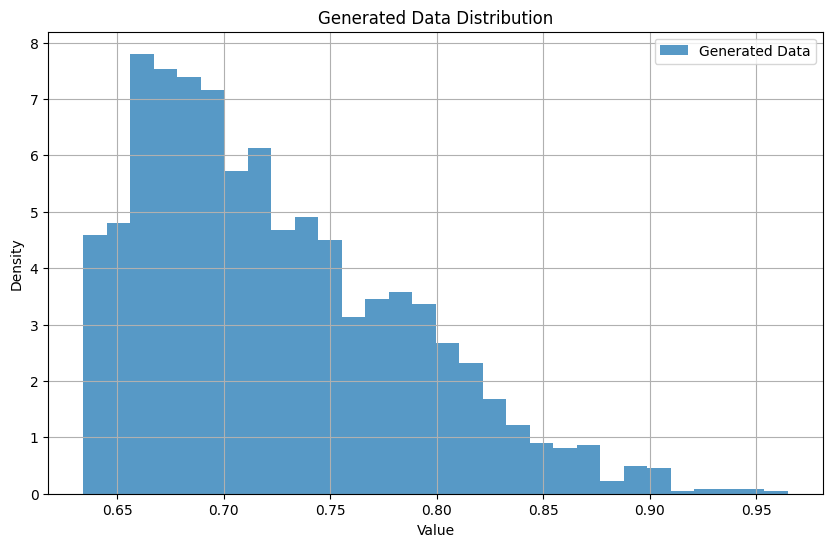

In [ ]:
import numpy as np

model.eval()
with torch.no_grad():
    z = torch.randn(1000, latent_dim).to(device)
    generated_data = model.decode(z).cpu().numpy()

# Plot the generated data distribution
plt.figure(figsize=(10, 6))
plt.title("Generated Data Distribution")
plt.hist(generated_data.flatten(), bins=30, density=True, alpha=0.75, label='Generated Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


**Step 5: Validate the Model**

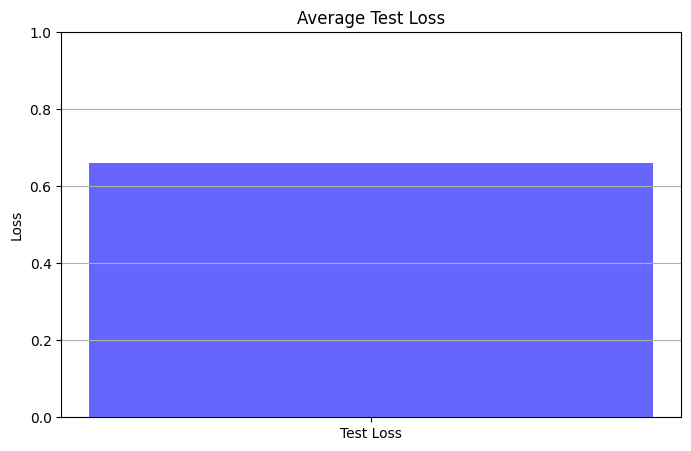

In [ ]:
model.eval()
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        data = data.clamp(0, 1)  # Ensure data is between 0 and 1
        recon_batch, mean, logvar = model(data)
        loss = loss_function(recon_batch, data, mean, logvar)
        test_loss += loss.item()

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader.dataset)

# Display test loss
plt.figure(figsize=(8, 5))
plt.bar(['Test Loss'], [avg_test_loss], color='blue', alpha=0.6)
plt.title('Average Test Loss')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


**Step 6: Integration into Simulations for Treatment Planning**

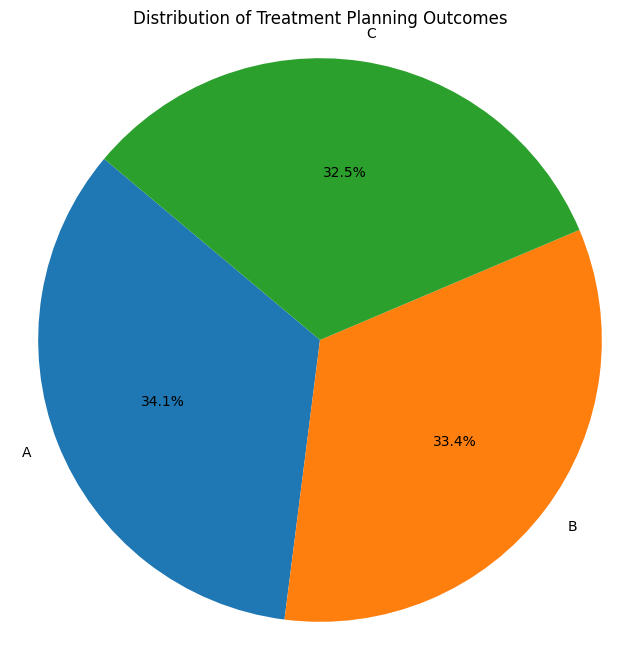

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to simulate treatment planning based on generated synthetic data
def treatment_planning(generated_data):
    # Placeholder logic: Generate random treatment outcomes (example)
    treatment_outcomes = np.random.choice(['A', 'B', 'C'], size=len(generated_data))

    return treatment_outcomes

# Simulate treatment planning
treatment_outcomes = treatment_planning(generated_data)

# Count the frequency of each treatment option
unique_treatments, counts = np.unique(treatment_outcomes, return_counts=True)

# Plotting a pie chart for treatment outcomes
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_treatments, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Treatment Planning Outcomes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
